In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-12-16 14:19:05--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-12-16 14:19:05 (5.82 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



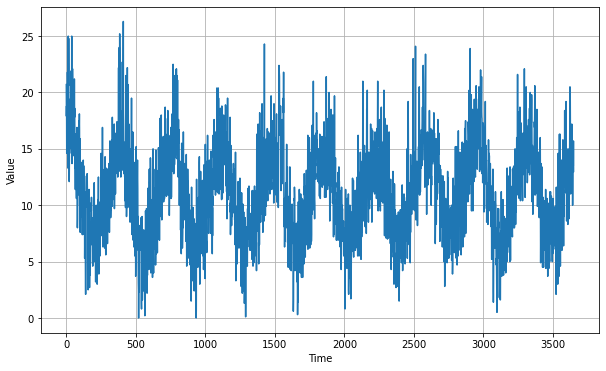

In [5]:
import csv
time_step = []
temps = []
count=-1
with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
     reader=csv.reader(csvfile, delimiter=',')
     next(reader)
     for row in reader:
         count+=1
         time_step.append(count)
         temps.append(float(row[1]))
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [31]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid =time[split_time:]
x_valid =series[split_time:]

window_size = 40
batch_size = 64
shuffle_buffer_size = 1000


In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [21]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    forecast=[]
    for time in range(len(series) - window_size):
          forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results



In [46]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    #tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3741 - mae: 7.8695
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3723 - mae: 7.8677
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3700 - mae: 7.8654
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3674 - mae: 7.8628
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3645 - mae: 7.8599
Epoch 6/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3613 - mae: 7.8566
Epoch 7/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3576 - mae: 7.8530
Epoch 8/100
25/25 [==============================] - 0s 9ms/step - loss: 7.3535 - mae: 7.8488
Epoch 9/100
25/25 [==============================] - 0s 8ms/step - loss: 7.3489 - mae: 7.8442
Epoch 10/100
25/25 [==============================] - 0s 10ms/s

(1e-08, 0.0001, 0.0, 60.0)

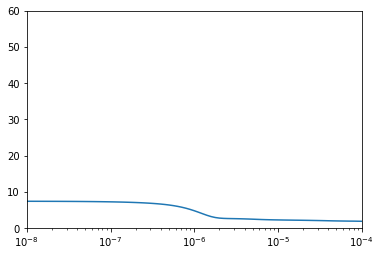

In [47]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [53]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
 tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    #tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=5*1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30,verbose=1)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 0s 10ms/step - loss: 3.2273 - mae: 3.6966
Epoch 2/30
25/25 [==============================] - 0s 11ms/step - loss: 1.9197 - mae: 2.3707
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 1.8309 - mae: 2.2840
Epoch 4/30
25/25 [==============================] - 0s 11ms/step - loss: 1.7765 - mae: 2.2280
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 1.7482 - mae: 2.1992
Epoch 6/30
25/25 [==============================] - 0s 12ms/step - loss: 1.7462 - mae: 2.1964
Epoch 7/30
25/25 [==============================] - 0s 11ms/step - loss: 1.7052 - mae: 2.1574
Epoch 8/30
25/25 [==============================] - 0s 9ms/step - loss: 1.6994 - mae: 2.1508
Epoch 9/30
25/25 [==============================] - 0s 10ms/step - loss: 1.6818 - mae: 2.1343
Epoch 10/30
25/25 [==============================] - 0s 10ms/step - loss: 1.6489 - mae: 2.0991
Epoch 11/30
25/25 [==============================] - 0s 10ms/

In [63]:
#rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = model_forecast(model, series[:,-1,0], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

IndexError: ignored

In [64]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [65]:
rnn_forecast=results

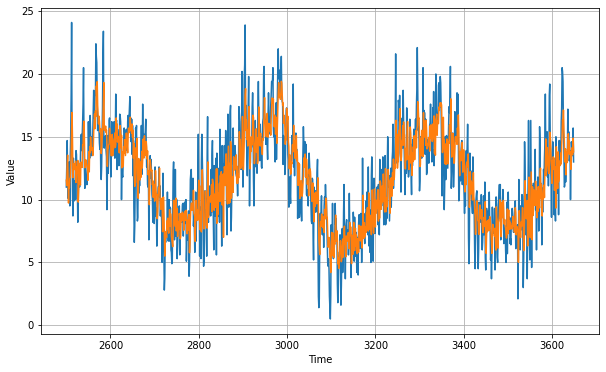

In [66]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [67]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8389664

In [68]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.543202 11.113846 12.903197 ... 13.570534 14.89222  13.810106]
